In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pyproj import CRS, Transformer
import re
import xarray as xr

import matplotlib.patheffects as pe
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Seaborn aesthetics
sns.set_context("notebook")
sns.set_theme(style="whitegrid", font_scale=1.4,
              rc={'grid.color': '#ededed'})

In [2]:
# Read the curated tree data
appidv_all = pd.read_csv("../data/output/NEON_VEGSTRUCTURE_FIRSTMSMTS.csv")


/tmp/ipykernel_909460/3803595859.py:2: DtypeWarning: Columns (14,27,28,33,38) have mixed types. Specify dtype option on import or set low_memory=False.
  appidv_all = pd.read_csv("../data/output/NEON_VEGSTRUCTURE_FIRSTMSMTS.csv")


In [3]:
# Use only live trees
appidv_all = appidv_all[~appidv_all['plantStatus'].str.contains("dead")].reset_index(drop=True)

# Get average crownd diameter
appidv_all["avgCrownDiameter"] = (appidv_all["maxCrownDiameter"] + appidv_all["ninetyCrownDiameter"])/2
# Get vertical crown diameter
appidv_all["verticalDiameter"] = appidv_all["height"] - appidv_all["baseCrownHeight"]
# calculate crown volume 
hrad = appidv_all["avgCrownDiameter"]/2
vrad = appidv_all["verticalDiameter"]/2
# appidv_all['crown_vol'] =(4/3) * np.pi * (hrad**2) * (vrad)
appidv_all['crown_vol'] =(4/3) * np.pi * (hrad**2) * ((1/4)*appidv_all["height"])

In [4]:
# Filter out small veg
# appidv_all_filt = appidv_all.loc[appidv_all['stemDiameter']>5].copy()
# appidv_all_filt = appidv_all_filt.loc[appidv_all_filt['height']>2].copy()
# appidv_all_copy_filt = appidv_all_copy_filt.loc[appidv_all_copy_filt['maxCrownDiameter']>1].copy()

In [9]:
## Clean data
# remember to divide by 100 for stemDiameter in meters!
appidv_all['stemDiameter_m'] = appidv_all['stemDiameter']/100
appidv_all['crownRadius'] = appidv_all['avgCrownDiameter']/2
appidv_all['verticalCrownRadius'] = appidv_all['verticalDiameter']/2

# Remove data with errors (large DBH, height, etc.)
treeid_list = ['NEON.PLA.D01.BART.05414', 'NEON.PLA.D01.HARV.05718',
       'NEON.PLA.D01.HARV.05764', 'NEON.PLA.D03.JERC.00993',
       'NEON.PLA.D08.TALL.01932', 'NEON.PLA.D05.TREE.00161']
appidv_all_clean = appidv_all[~appidv_all['individualID'].isin(treeid_list)].copy().reset_index(drop=True)

# filter for only trees
growthForm_list = ['single bole tree', 'multi-bole tree'] # 'small tree'
# growthForm_list = ['small tree']
appidv_all_clean = appidv_all_clean[appidv_all_clean['growthForm'].isin(growthForm_list)].copy()
appidv_all_clean = appidv_all_clean[appidv_all_clean['plantStatus']=="Live"].copy().reset_index(drop=True)

In [10]:
## Lets get lat lon for each tree

# read in metadata for utm zone
neon_meta = pd.read_csv("../data/NEON_Field_Site_Metadata_20230309.csv")
# get utm zone (option 1 - faster way)
# utm_num = re.findall('\d+', "UTM18N")[0]
neon_meta['utm_num'] =  [re.findall('\d+', str(x))[0] for x in neon_meta['field_utm_zone']]

# Loop through each site, reproject from utmzone to latlon
df_list = []
for name,group in appidv_all_clean.groupby("siteID"):
    
    # Get EPSG code for UTM zone
    utm_num = neon_meta.loc[neon_meta["field_domain_id"]==group['domainID'].values[0]]["utm_num"].values[0]
    crs = CRS.from_string(f"+proj=utm +zone={utm_num} +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    
    # Get easting and northing
    x = group['easting'].values
    y = group['northing'].values
    
    from_crs = CRS.from_proj4(f"+proj=utm +zone={utm_num} +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    to_crs = CRS.from_epsg(4326)

    proj = Transformer.from_crs(from_crs, to_crs, always_xy=True)
    coordinates = proj.transform(x, y)
    group["lon"] = coordinates[0]
    group["lat"] = coordinates[1]
    df_list.append(group)

# Combine and replace inf with nan
appidv_all_latlon = pd.concat(df_list)
appidv_all_latlon.loc[~np.isfinite(appidv_all_latlon["lon"].values), "lon"]=np.nan
appidv_all_latlon.loc[~np.isfinite(appidv_all_latlon["lat"].values), "lat"]=np.nan

In [11]:
appidv_all_latlon.columns

Index(['uid', 'namedLocation', 'date', 'eventID', 'domainID', 'siteID',
       'plotID', 'individualID', 'tempStemID', 'tagStatus', 'growthForm',
       'plantStatus', 'stemDiameter', 'measurementHeight',
       'changedMeasurementLocation', 'height', 'baseCrownHeight',
       'breakHeight', 'breakDiameter', 'maxCrownDiameter',
       'ninetyCrownDiameter', 'canopyPosition', 'shape', 'basalStemDiameter',
       'basalStemDiameterMsrmntHeight', 'maxBaseCrownDiameter',
       'ninetyBaseCrownDiameter', 'dendrometerInstallationDate',
       'initialGapMeasurementDate', 'initialBandStemDiameter',
       'initialDendrometerGap', 'dendrometerHeight', 'dendrometerGap',
       'dendrometerCondition', 'bandStemDiameter', 'remarks', 'recordedBy',
       'measuredBy', 'dataEntryRecordID', 'dataQF', 'subplotID', 'taxonID',
       'scientificName', 'easting', 'northing', 'avgCrownDiameter',
       'verticalDiameter', 'crown_vol', 'stemDiameter_m', 'crownRadius',
       'verticalCrownRadius', 'lon',

In [12]:
print(appidv_all_clean.shape)
print(appidv_all_latlon.shape)

(65562, 51)
(65562, 53)


In [13]:
# Lets run the point extrction


In [14]:
import rioxarray as rioxr

In [15]:
fp = "../data/raw/raster/AI_NA_clipped.tif"
rarr = rioxr.open_rasterio(fp,mask_and_scale=True)


In [16]:
import xarray as xr
# Sample the rasters at the point locations
x_indexer = xr.DataArray(appidv_all_latlon["lon"].values, dims=["point"])
y_indexer = xr.DataArray(appidv_all_latlon["lat"].values, dims=["point"])

In [17]:
x_indexer

<xarray.DataArray (point: 65562)>
array([-122.32977002, -122.32710713, -122.3250482 , ..., -110.53653842,
       -110.53653842, -110.43354318])
Dimensions without coordinates: point

In [19]:
# rarr.x

In [20]:
# Sample Aridity raster, then check if shapes match
sampled_raster_vals = rarr.sel(x=x_indexer, y=y_indexer, method="nearest")

In [21]:
print(sampled_raster_vals.values[0].shape)
print(x_indexer.shape)

(65562,)
(65562,)


In [22]:
# add sampled values to the dataframe
appidv_all_latlon['AI'] = sampled_raster_vals.values[0]/10000

In [24]:
sampled_raster_vals.values

array([[26322., 26322., 26322., ...,  6296.,  6296.,  4944.]])

In [28]:
np.isnan(sampled_raster_vals.values).any()

True

In [31]:
sampled_raster_vals.values[~np.isnan(sampled_raster_vals.values)].shape

(58052,)

In [35]:
# get colors for plotting
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize, rgb2hex

cmap = get_cmap('tab20', 20)
cmap_list = []
for i in range(cmap.N):
    rgba=cmap(i)
    cmap_list.append(rgb2hex(rgba))

print(cmap_list)

['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']


/tmp/ipykernel_3076229/3656774359.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', 20)


Not enough crown radius data for regression at domain: D14
Not enough crownRadius data for regression at domain: D14
Not enough crown_vol data for regression at domain: D14


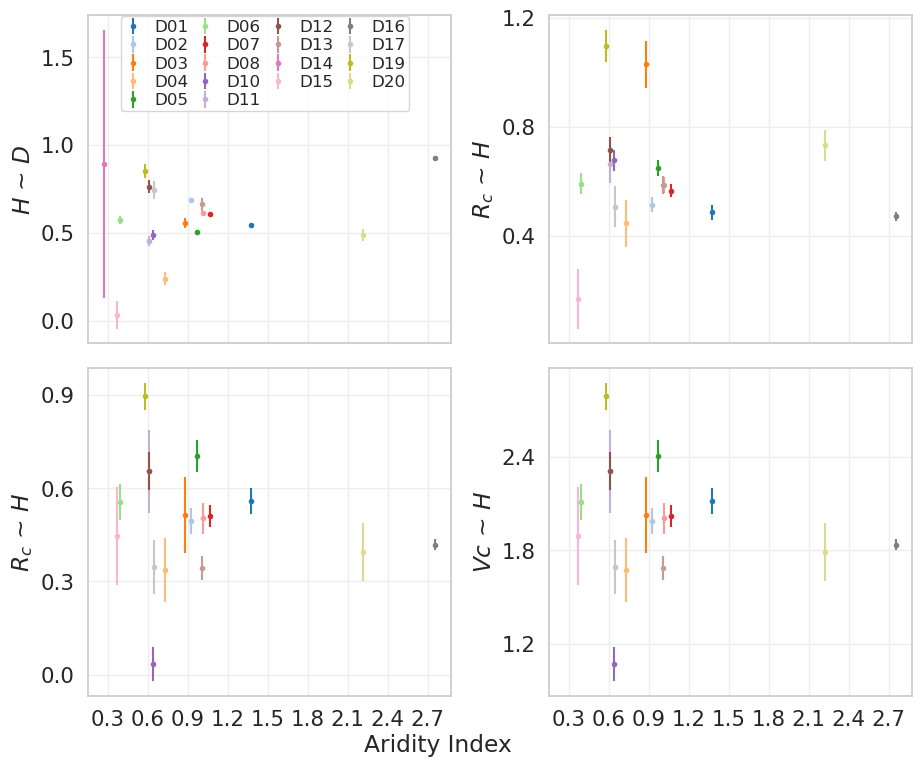

In [55]:
# Lets rerun some analysis using (copy figure 2 from Tallo paper)
# Get HSE for:
# H ~ D
# CR ~ D
# CR ~ H
# VC ~ H
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import MaxNLocator
# Init plot
fig,axs = plt.subplots(2,2,figsize=(10,8),sharex=True)
ax = axs.flatten()
color_idx = 0

# for each domain, get regression then plot
for domain, dgroup in appidv_all_latlon.groupby("domainID"):
    
    # Get average AI
    ai_avg = dgroup['AI'].mean()
    
    ## H ~ D
    # Get x,y, then perform regression
    x = np.log(dgroup['stemDiameter'].values)
    y = np.log(dgroup['height'].values)
    filt_bool = (np.isfinite(x) & np.isfinite(y))
    x = x[filt_bool]
    y = y[filt_bool]
    
    # Run simple OLS regression and get confidence intervals
    alpha = 0.05 # 95% confidence interval
    lr = sm.OLS(y, sm.add_constant(x,prepend=False)).fit()
    conf_interval = lr.conf_int(alpha)
    
    # Plot
    ax[0].errorbar(ai_avg, lr.params[0], yerr=conf_interval[0][1]-lr.params[0],fmt=".",
                   label=domain,color=cmap_list[color_idx])
#     ax[0].scatter(ai_avg, lr.params[0], cmap="tab20")
    ax[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
    ax[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
    
    
    ## CR ~ D
    # Get x,y, then perform regression
    x = np.log(dgroup['stemDiameter'].values)
    y = np.log(dgroup['crownRadius'].values)
    filt_bool = (np.isfinite(x) & np.isfinite(y))
    x = x[filt_bool]
    y = y[filt_bool]
    
    try:
        # Run simple OLS regression and get confidence intervals
        alpha = 0.05 # 95% confidence interval
        lr = sm.OLS(y, sm.add_constant(x,prepend=False)).fit()
        conf_interval = lr.conf_int(alpha)
        # Plot
        ax[1].errorbar(ai_avg, lr.params[0], yerr=conf_interval[0][1]-lr.params[0],fmt=".",
                       label=domain,color=cmap_list[color_idx])
        ax[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        
    except:
        print(f"Not enough crown radius data for regression at domain: {domain}")
    
    
    ## CR ~ H
    # Get x,y, then perform regression
    x = np.log(dgroup['height'].values)
    y = np.log(dgroup['crownRadius'].values)
    filt_bool = (np.isfinite(x) & np.isfinite(y))
    x = x[filt_bool]
    y = y[filt_bool]
    
    try:
        # Run simple OLS regression and get confidence intervals
        alpha = 0.05 # 95% confidence interval
        lr = sm.OLS(y, sm.add_constant(x,prepend=False)).fit()
        conf_interval = lr.conf_int(alpha)

        # Plot
        ax[2].errorbar(ai_avg, lr.params[0], yerr=conf_interval[0][1]-lr.params[0],fmt=".",
                       label=domain,color=cmap_list[color_idx])
        ax[2].yaxis.set_major_locator(MaxNLocator(nbins=4))
        
    except:
        print(f"Not enough crownRadius data for regression at domain: {domain}")
    
    ## Vc ~ H
    # Get x,y, then perform regression
    x = np.log(dgroup['height'].values)
    y = np.log(dgroup['crown_vol'].values)
    filt_bool = (np.isfinite(x) & np.isfinite(y))
    x = x[filt_bool]
    y = y[filt_bool]
    
    try:
        # Run simple OLS regression and get confidence intervals
        alpha = 0.05 # 95% confidence interval
        lr = sm.OLS(y, sm.add_constant(x,prepend=False)).fit()
        conf_interval = lr.conf_int(alpha)

        # Plot
        ax[3].errorbar(ai_avg, lr.params[0], yerr=conf_interval[0][1]-lr.params[0],fmt=".",
                       label=domain,color=cmap_list[color_idx])
        ax[3].yaxis.set_major_locator(MaxNLocator(nbins=4))
        
    except:
        print(f"Not enough crown_vol data for regression at domain: {domain}")
    
    color_idx+=1
##################
    
## Subplot aesthetics
ax[0].set_ylabel("$H$ ~ $D$")
ax[1].set_ylabel("$R_{c}$ ~ $H$")
ax[2].set_ylabel("$R_{c}$ ~ $H$")
ax[3].set_ylabel("$Vc$ ~ $H$")
# ax[3].set_xlabel("Aridity Index")
fig.text(0.5, 0.04, 'Aridity Index', ha='center')

h,l = ax[0].get_legend_handles_labels()
# ax[0].set_ylim(0,50)
fig.tight_layout()
fig.legend(h,l, loc="upper left", ncols=4,fontsize=12,bbox_to_anchor=(0.175,0.97),
           borderpad=0.2,labelspacing=0.2,handlelength=1,columnspacing=0.5)
fig.subplots_adjust(bottom=0.11,left=0.15)
fig.savefig("../figs/veg-struct/allom/DOMAINS-SCALINGEXPONENTS-AI.png", dpi=300)
plt.show()



2.54756479710444
1.9176147646661665
2.5615164296183193
7.631338544254497
2.5302394897832077
2.3695008887601294
2.2747076966008306
2.2494904256636317
4.01939252126895
3.087120890715742
1.3104368025867137
2.3352669620658215
Not enough crown_vol data for regression at domain: D14
57.55610172466254
1.3226275260559228
1.9934248027552346
0.5582874782120877
3.3084644129152023


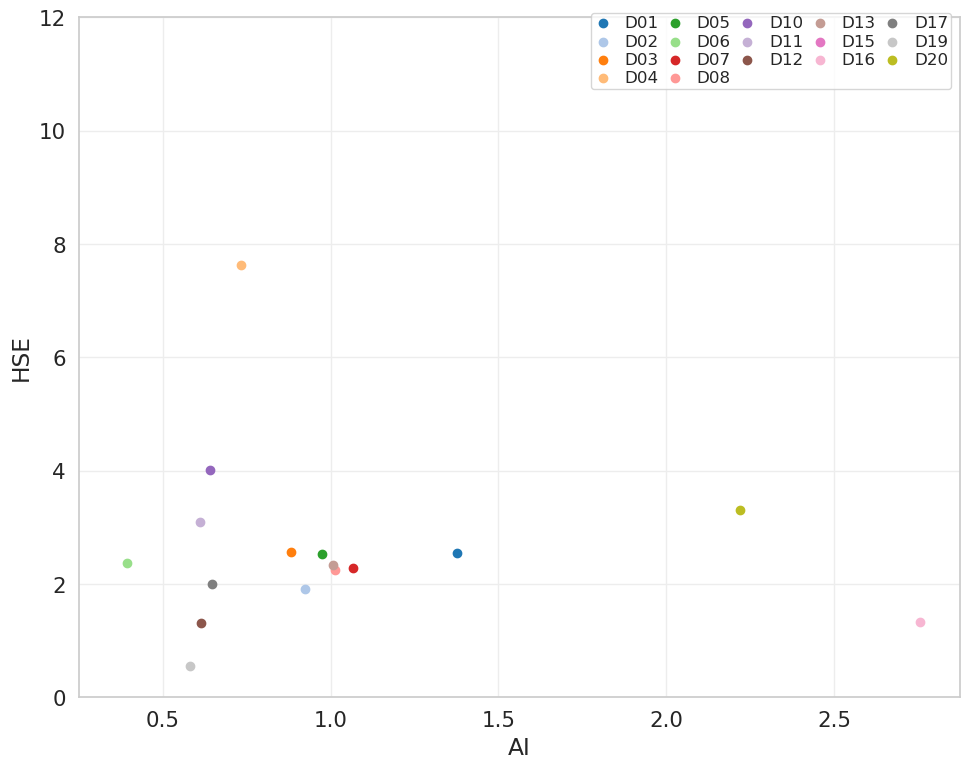

In [57]:
# Lets rerun some analysis using (copy figure 2 from Tallo paper)
# Get HSE for:
# H ~ D
# CR ~ D
# CR ~ H
# VC ~ H
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import MaxNLocator
# Init plot
fig,ax = plt.subplots(1,figsize=(10,8),sharex=True)
color_idx = 0

# for each domain, get regression then plot
for domain, dgroup in appidv_all_latlon.groupby("domainID"):
    
    # Get average AI
    ai_avg = dgroup['AI'].mean()
    
    ## H ~ D
    # Get x,y, then perform regression
    x = np.log(dgroup['stemDiameter'].values)
    y = np.log(dgroup['height'].values)
    filt_bool = (np.isfinite(x) & np.isfinite(y))
    x = x[filt_bool]
    y = y[filt_bool]
    
    # Run simple OLS regression
    lr = sm.OLS(y, sm.add_constant(x,prepend=False)).fit()
    beta = lr.params[0]
    # 95% confidence interval
    conf_interval_beta = lr.conf_int(0.05)
    
    
    ## Vc ~ H
    # Get x,y, then perform regression
    x = np.log(dgroup['height'].values)
    y = np.log(dgroup['crown_vol'].values)
    filt_bool = (np.isfinite(x) & np.isfinite(y))
    x = x[filt_bool]
    y = y[filt_bool]
    
    try:
        # Run simple OLS regression and get confidence intervals
        lr = sm.OLS(y, sm.add_constant(x,prepend=False)).fit()
        alpha = lr.params[0] # 95% confidence interval
        conf_interval_alpha = lr.conf_int(0.05)
        
    except:
        print(f"Not enough crown_vol data for regression at domain: {domain}")
        continue
        
    # Get HSE and plot!
    HSE = (1+2/beta)-alpha
    print(HSE)
    # Plot
    ax.scatter(ai_avg, HSE,label=domain,color=cmap_list[color_idx])
    
    color_idx+=1
##################
    
## Subplot aesthetics
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))

ax.set_ylim(0, 12)

ax.set_xlabel("AI")
ax.set_ylabel("HSE")
h,l = ax.get_legend_handles_labels()
# ax[0].set_ylim(0,50)
fig.tight_layout()
fig.legend(h,l, loc="upper right", ncols=5,fontsize=12,bbox_to_anchor=(0.975,0.975),
           borderpad=0.2,labelspacing=0.2,handlelength=1,columnspacing=0.5)
fig.savefig("../figs/veg-struct/allom/DOMAINS-HSE-AI.png", dpi=300)
plt.show()

